#Understanding the Dataset

In [1]:
!git clone https://github.com/udacity/P1_Facial_Keypoints.git

Cloning into 'P1_Facial_Keypoints'...
remote: Enumerating objects: 5984, done.
remote: Total 5984 (delta 0), reused 0 (delta 0), pack-reused 5984
Receiving objects: 100% (5984/5984), 329.49 MiB | 39.39 MiB/s, done.
Resolving deltas: 100% (126/126), done.
Checking out files: 100% (5803/5803), done.


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

In [0]:
def plot(image,key_pts):
      plt.imshow(image)
      plt.scatter(key_pts[:,0],key_pts[:,1],s=5,marker='.',c='m')

def visualize(csv_path,root_dir,index):
      train_csv = pd.read_csv(csv_path)
      n = index
      image_name = train_csv.iloc[n,0]
      key_pts = train_csv.iloc[n,1:].values
      key_pts = key_pts.astype('float').reshape(-1, 2)
      image = cv2.imread(os.path.join(root_dir,image_name))
      plot(image,key_pts)

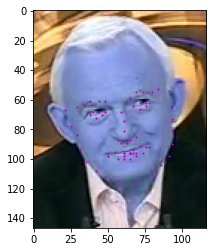

In [4]:
visualize('P1_Facial_Keypoints/data/training_frames_keypoints.csv'
            ,'P1_Facial_Keypoints/data/training',100)

In [0]:
import torch
from torch.utils.data import Dataset,DataLoader

class FacialKeyPointsDataset(torch.utils.data.Dataset):
  def __init__(self,csv_path,root_dir,transform=None):
    self.csv_file = pd.read_csv(csv_path)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.csv_file)

  def __getitem__(self,idx):
    image = cv2.imread(os.path.join(self.root_dir,
                                    self.csv_file.iloc[idx,0]))
    
    #If Image has alpha channel,neglect it
    if (image.shape[2]==4):
      image = image[:,:,0:3]

    key_pts = self.csv_file.iloc[idx,1:].values
    key_pts = key_pts.astype('float').reshape(-1, 2)
    sample = {'image':image,'keypoints':key_pts}

    if self.transform != None:
      sample = self.transform(sample)

    return sample

In [6]:
face_dataset = FacialKeyPointsDataset('P1_Facial_Keypoints/data/training_frames_keypoints.csv',
                                      'P1_Facial_Keypoints/data/training')
print(len(face_dataset))

3462


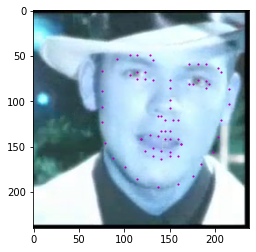

In [7]:
#Display an Image
plot(face_dataset[200]['image'],face_dataset[200]['keypoints'])

# Transformations

In [0]:
import torch
from torchvision import transforms, utils
# tranforms

class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""        

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # convert image to grayscale
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
        
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        key_pts_copy = (key_pts_copy - 100)/50.0


        return {'image': image_copy, 'keypoints': key_pts_copy}


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        
        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': key_pts}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
         
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}

#Dataset

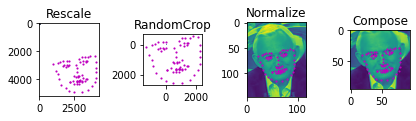

In [9]:
# test out some of these transforms
rescale = Rescale(100)
crop = RandomCrop(50)
gray = Normalize()
composed = transforms.Compose([
                               Rescale(100),
                               RandomCrop(96),
                               Normalize()
                               ])

# apply the transforms to a sample image
test_num = 100
sample = face_dataset[test_num]

fig = plt.figure()
for i, tx in enumerate([rescale, crop,gray, composed]):
    transformed_sample = tx(sample)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    plot(transformed_sample['image'], (transformed_sample['keypoints']*50.0+100))

plt.show()

# Model Architecture

In [0]:
import torch
from torch import nn
import torch.nn.functional as F

In [0]:
class Network(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,32,3,padding=1)
    self.batchnorm1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32,32,3,padding=1)
    self.batchnorm2 = nn.BatchNorm2d(32)
    self.maxpool1 = nn.MaxPool2d(2)

    self.conv3 = nn.Conv2d(32,64,3,padding=1)
    self.batchnorm3 = nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(64,64,3,padding=1)
    self.batchnorm4 = nn.BatchNorm2d(64)
    self.maxpool2 = nn.MaxPool2d(2)

    self.conv5 = nn.Conv2d(64,128,3,padding=1)
    self.batchnorm5 = nn.BatchNorm2d(128)
    self.conv6 = nn.Conv2d(128,128,3,padding=1)
    self.batchnorm6 = nn.BatchNorm2d(128)
    self.maxpool3 = nn.MaxPool2d(2)

    self.conv7 = nn.Conv2d(128,256,3,padding=1)
    self.batchnorm7 = nn.BatchNorm2d(256)
    self.maxpool4 = nn.MaxPool2d(2)
    self.conv8 = nn.Conv2d(256,512,3,padding=1)
    self.batchnorm8 = nn.BatchNorm2d(512)
    self.maxpool5 = nn.MaxPool2d(2)
    self.drop1 = nn.Dropout2d(0.3)

    # self.conv9 = nn.Conv2d(256,512,3,padding=1)
    # self.batchnorm9 = nn.BatchNorm2d(512)
    # self.conv10 = nn.Conv2d(512,512,3,padding=1)
    # self.batchnorm10 = nn.BatchNorm2d(512)
    # self.maxpool5 = nn.MaxPool2d(2)
    # self.drop1 = nn.Dropout2d(0.4)

    self.dense1 = nn.Linear(4608,1000)
    self.drop2 = nn.Dropout2d(0.2)

    self.dense2 = nn.Linear(1000,500)
    self.drop3 = nn.Dropout2d(0.2)


    self.dense3 = nn.Linear(500,136)


  def forward(self,x):
    x = self.maxpool1(self.batchnorm2(F.relu((self.conv2(self.batchnorm1(F.relu(self.conv1(x))))))))
    x = self.maxpool2(self.batchnorm4(F.relu((self.conv4(self.batchnorm3(F.relu(self.conv3(x))))))))
    x = self.maxpool3(self.batchnorm6(F.relu((self.conv6(self.batchnorm5(F.relu(self.conv5(x))))))))
    x = self.drop1(self.maxpool5(self.batchnorm8(F.relu((self.conv8(
        self.maxpool4(self.batchnorm7(F.relu(self.conv7(x))))))))))
    # x = self.maxpool5(self.batchnorm10(F.relu((self.conv10(self.batchnorm9(F.relu(self.conv9(x))))))))

    x = x.view(x.size(0),-1)

    x = self.drop2(F.relu(self.dense1(x)))
    x = self.drop3(F.relu(self.dense2(x)))  
    x = self.dense3(x) 

    return x

In [142]:
net = Network()
net

Network(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm5): BatchNorm2d(128, eps=1e-05, 

In [143]:
for layer in net.modules():
  if(type(layer) != Network):
    if(type(layer)!=nn.MaxPool2d and type(layer)!=nn.BatchNorm2d
       and type(layer)!=nn.Dropout2d):
          nn.init.xavier_uniform_(layer.weight)
          print("Done")

Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done


# Dataset Loader

In [0]:
data_transform = transforms.Compose([
                                     Rescale(100),
                                     RandomCrop(96),
                                     Normalize(),
                                     ToTensor()
                                        ])

transformed_dataset = FacialKeyPointsDataset('P1_Facial_Keypoints/data/training_frames_keypoints.csv',
                                      'P1_Facial_Keypoints/data/training',data_transform)
train_loader = torch.utils.data.DataLoader(transformed_dataset,64,shuffle=True,num_workers=4)


transformed_dataset_t = FacialKeyPointsDataset('P1_Facial_Keypoints/data/test_frames_keypoints.csv',
                                      'P1_Facial_Keypoints/data/test',data_transform)
test_loader = torch.utils.data.DataLoader(transformed_dataset_t,64,num_workers=4)

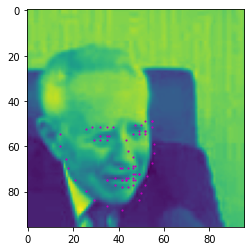

In [112]:
temp = next(iter(train_loader))
images,key_pts = temp['image'],temp['keypoints']
image=images[1].permute(1,2,0).squeeze()
plot(image,key_pts[1]*50+100)

#Training the Model

In [0]:
from torch import optim
criterian = nn.MSELoss()
optimizer = optim.RMSprop(net.parameters(),lr=0.001)

In [0]:
def train(epochs,net):
  net.train()
  net.to('cuda')
  for i in range(epochs):
      running_loss = 0.0
      for ii,samples in enumerate(iter(train_loader)):
        optimizer.zero_grad()
        images = samples['image']
        labels = samples['keypoints']

        #Flatten Key Points
        labels = labels.view(labels.size(0),-1)
        
        labels = labels.type(torch.FloatTensor)
        images = images.type(torch.FloatTensor)
        images,labels = images.to('cuda'),labels.to('cuda')

        output_labels = net.forward(images)
        loss = criterian(output_labels,labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
      print("Epoch {}.........Loss {:.5f}".format(i,running_loss))
      running_loss = 0.0
  print("Fininshed Training")

In [0]:
epochs = 100
train(epochs=epochs,net=net)

Epoch 0.........Loss 0.12324
Epoch 1.........Loss 0.13576


In [0]:
torch.save(net.state_dict(),"keypoints_model.pth")

#Testing

In [0]:
index=50
net.eval()
net.to('cuda')
temp = next(iter(test_loader))
images,key_pts = temp['image'],temp['keypoints']
out = net.forward(images[index].unsqueeze(0).type(torch.FloatTensor).to('cuda'))
out = out.to('cpu').detach().numpy()
out = out.astype('float').reshape(-1,2)
image=images[index].permute(1,2,0).squeeze()

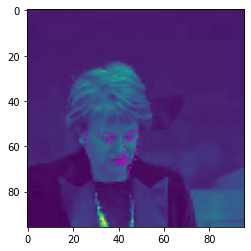

In [181]:
#Orginal
plot(image,key_pts[index]*50.0+100)

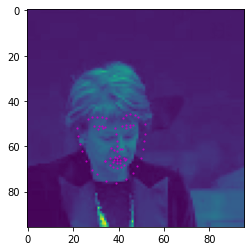

In [182]:
#Predicted
plot(image,out*50.0+100)

#Visualizing Features

In [0]:
weights1 = net.conv2.weights.data
w = weights.numpy()
filter_idx = 0
print(w.shape)
print(w[filter_idx].shape)